# Imports

In [1]:
import os

In [2]:
%cd ../..

c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica_numpy import fast_ica as fast_ica2
from mva_independent_component_analysis.fast_ica.fastica import fast_ica 


# Generating non-Gaussian sources and mixing them

In [4]:
# Set seed for reproducibility
np.random.seed(0)

# Generate time samples
t = np.linspace(0, 200, 1000)

# Sources
source_1 = np.sin(t*2)
source_2 = 2 * (1.9*t % (2 * np.pi)) / (2 * np.pi) - 1  # Sawtooth wave approximation
source_3 = np.random.random(len(t))

# Stack sources to form S matrix
S = np.array([source_1, source_2, source_3])

# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signals
X = A @ S

# Number of sources, samples, and signals
n_sources, n_samples = S.shape
n_signals = X.shape[0]


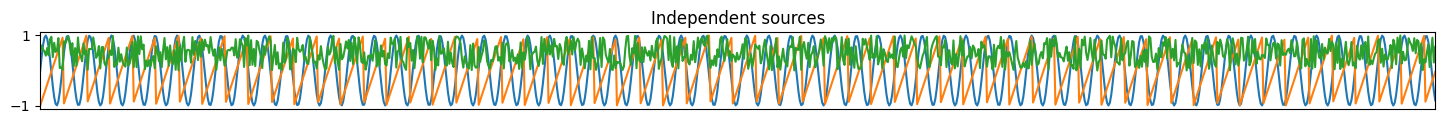

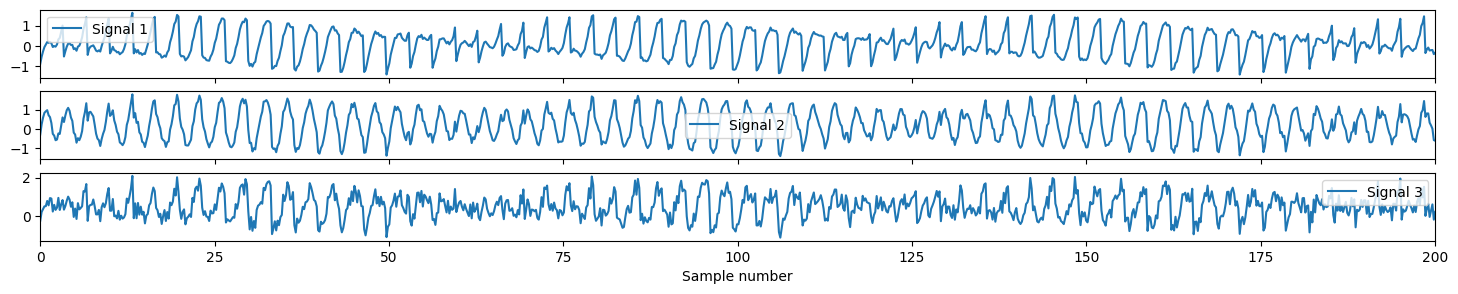

In [5]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 1])
ax.plot(t, S.T)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(t[0], t[-1])
ax.tick_params()
ax.set_title('Independent sources')

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(t, X[signal_number], label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params()
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number')
ax[-1].set_xlim(t[0], t[-1])
plt.show()

### A visual non-Gaussianity test

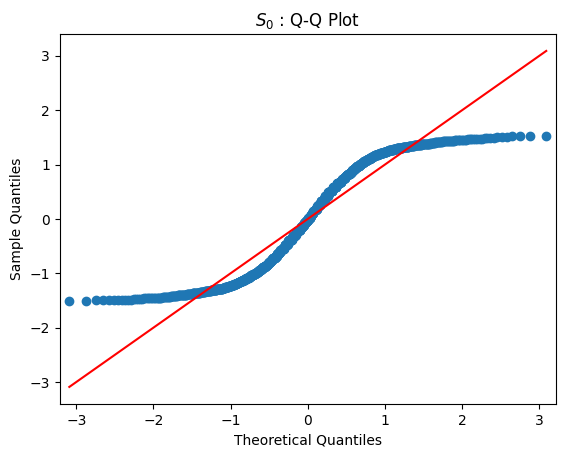

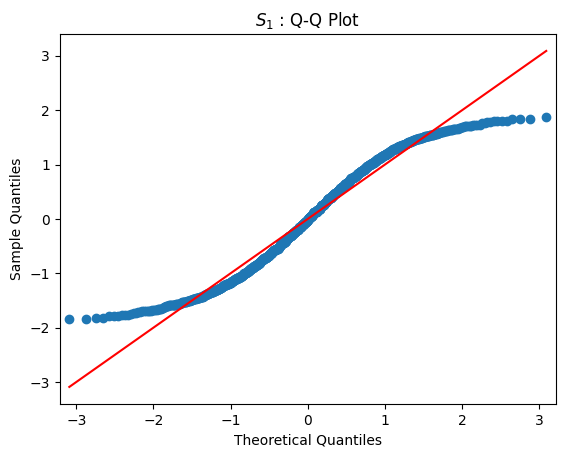

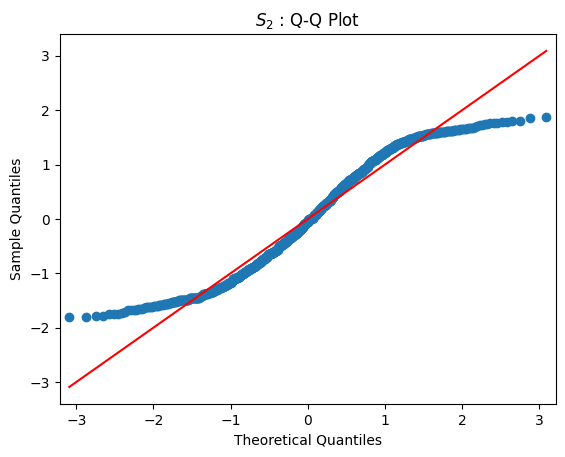

In [6]:
Sw, _, _ = centering_and_whitening(S)
import statsmodels.api as sm
# Create a Q-Q plot
for i in range(n_sources):
    sm.qqplot(Sw[i], line='s')
    plt.title(f'$S_{i}$ : Q-Q Plot')
    plt.show()


## ICA

In [7]:
# Center & whiten signals
import jax
OP_key = jax.random.PRNGKey(106)
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W = fast_ica(OP_key, X)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

Took 0.40271496772766113 s to run


In [8]:
import jax.numpy as jnp

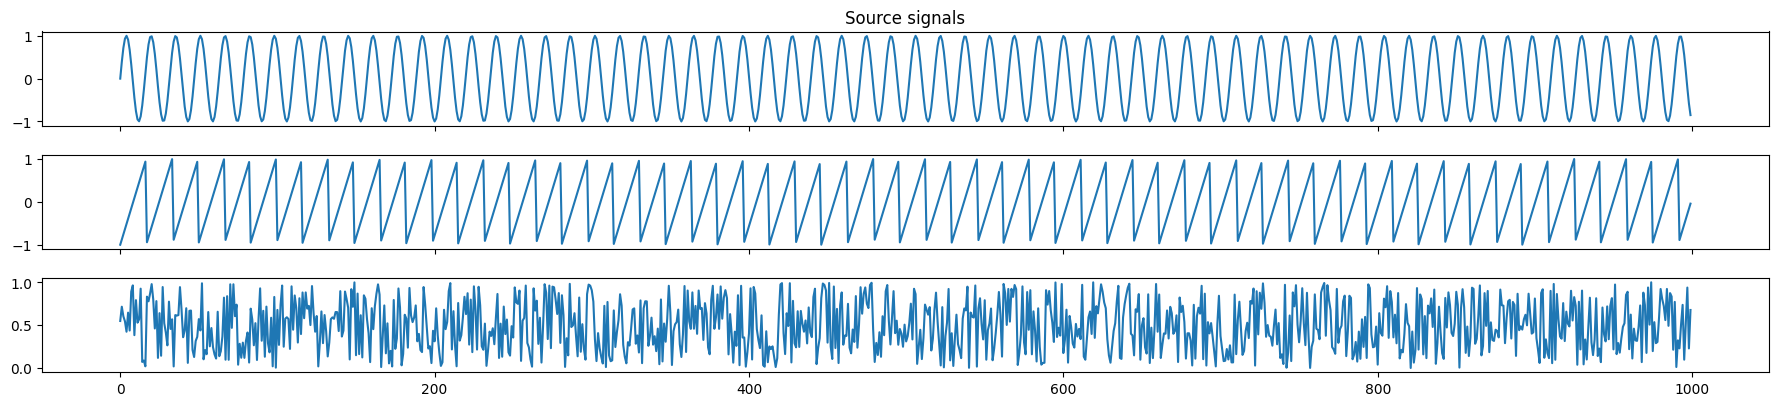

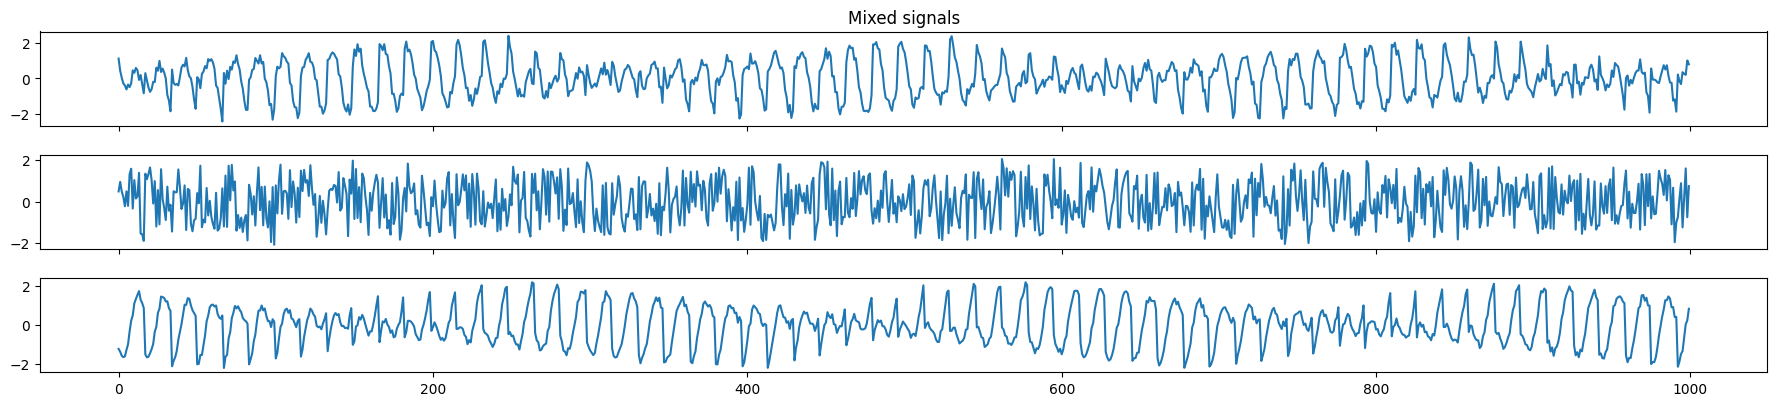

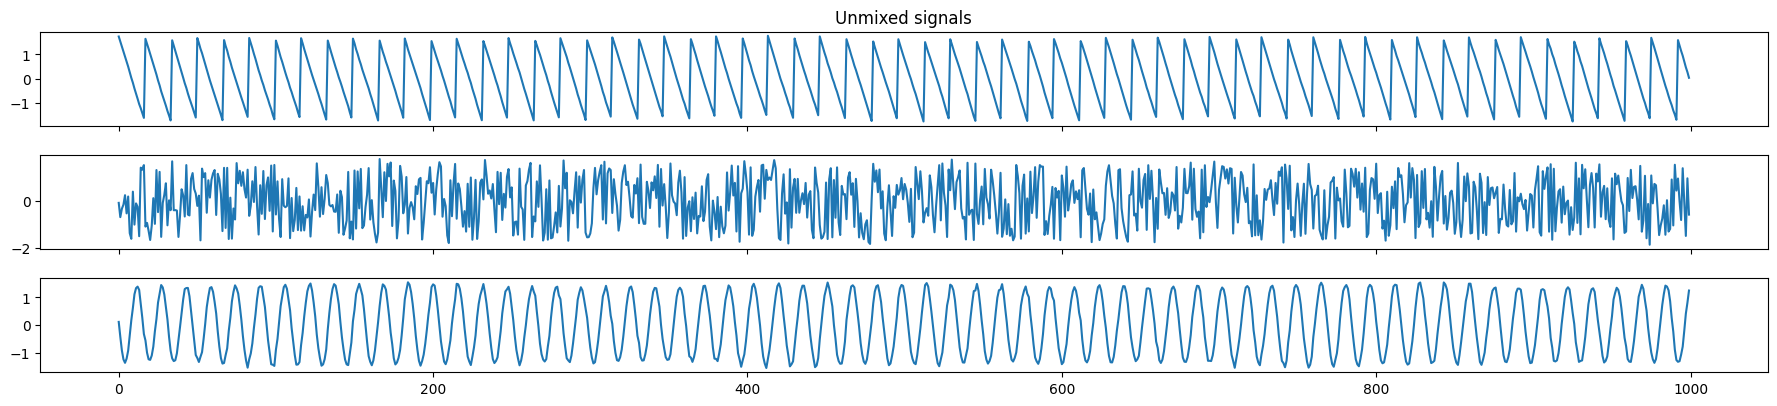

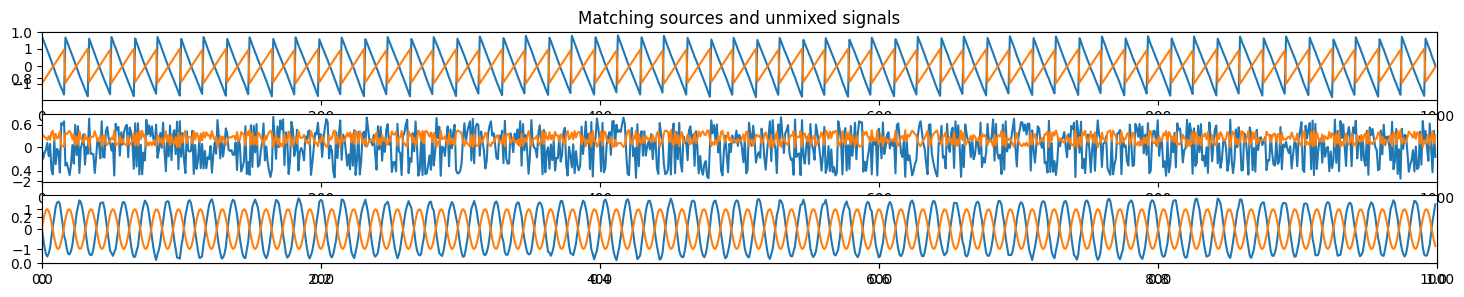

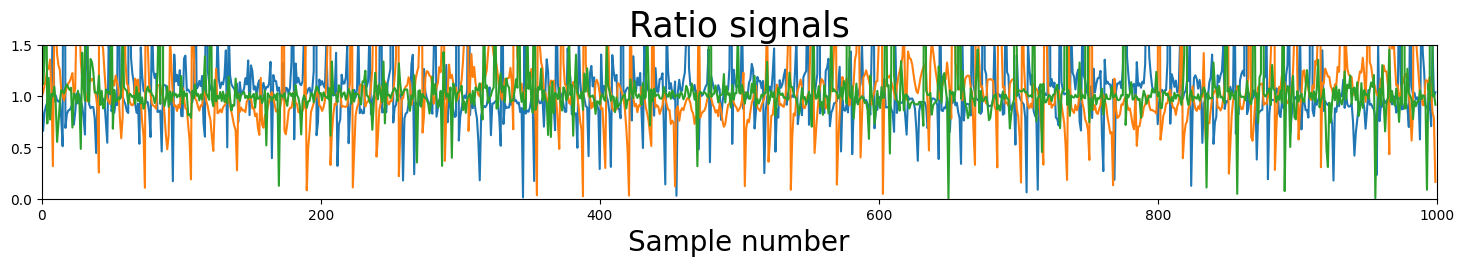

In [9]:
# Plot input signals (not mixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Source signals')
for i in range(n_signals):
    axes[i].plot(S[i])

# Plot mixed signals 
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Mixed signals')
for i in range(n_signals):
    axes[i].plot(X[i])


# Plot recovered signals (unmixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Unmixed signals')
for i in range(n_signals):
    axes[i].plot(unMixed[i])

Sw, _, _ = centering_and_whitening(S)

plt.figure(figsize=(18,3))
plt.title("Matching sources and unmixed signals")
for i in range(X.shape[0]):
    perm = np.argmax(np.abs(unMixed[i,:] @ Sw.T))
    plt.subplot(3,1,i+1)
    plt.plot(unMixed[i,:].T)
    plt.plot(S[perm].T)
    plt.xlim(0, S.shape[1])
    # ax.set_ylim(-1.5, 1.5)

Sw, _, _ = centering_and_whitening(S)
perm = jnp.argmax(jnp.abs(unMixed @ S.T),
                    axis=0)

fig, ax = plt.subplots(1, 1, figsize=[18, 2])
for i in range(n_sources):
    ax.plot(np.abs(unMixed[perm[i]] / Sw[i]), '-', label='Recovered signals')
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Ratio signals', fontsize=25)
ax.set_xlim(0, S.shape[1])
ax.set_ylim(0, 1.5)
plt.show()

# Figures in Latex

In [10]:
%pwd

'c:\\Users\\TRETEC\\Documents\\MVA\\S1\\[IPGM] Introduction to probabilistic graphical models\\Projet\\independent_component_analysis'

In [11]:
# Generate LaTeX code for the figure
latex_figure_code = r"""
\begin{figure}[H]
\centering
\begin{tikzpicture}
\begin{axis}[
    title={Ratio signals},
    xlabel={Sample number},
    ylabel={},
    xmin=0, xmax=1000,
    ymin=-1.5, ymax=1.5,
    legend pos=north east,
    xmajorgrids=true,
    ymajorgrids=true,
    grid style=dashed,
    width=\textwidth,
    height=8cm,
    label style={font=\large},
    title style={font=\Large},
]
"""

# Loop over each source to add plots to the LaTeX code
for i in range(n_sources):
    # Simulate the ratio signal
    ratio_signal = np.abs(unMixed[perm[i]] / Sw[i])
    # Create a data file for each source
    data_filename = f'report/data/ratio_toy_sources_{i+1}.dat'
    with open(data_filename, 'w') as f:
        for j in range(S.shape[1]):
            f.write(f"{j} {ratio_signal[j]:.2f}\n")
    
    # Add plot to the LaTeX code for each source
    latex_figure_code += rf"""\addplot[color=blue, no marks] table {{data/ratio_toy_sources_{i+1}.dat}};
    \addlegendentry{{Recovered signals {i+1}}}
"""

# Close the axis and tikzpicture environments
latex_figure_code += r"""
\end{axis}
\end{tikzpicture}
\caption{Plot of ratio signals for each source.}
\end{figure}
"""

# Save the LaTeX code to a .tex file
latex_file_path = 'report/figures_latex/ratio_toy_sources.tex'
with open(latex_file_path, 'w') as file:
    file.write(latex_figure_code)



In [12]:
# fast_ica version to get mcc scores
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W, mcc = fast_ica2(X, true_sources=S)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

component 0
iteration : 0 : distance 0.001308441162109375
----- MCC = 0.5301871399084727
iteration : 1 : distance 0.001270890235900879
----- MCC = 0.535231739282608
iteration : 2 : distance 0.0011638402938842773
----- MCC = 0.5394524236520132
iteration : 3 : distance 0.0010035037994384766
----- MCC = 0.5427843034267426
iteration : 4 : distance 0.0008179545402526855
----- MCC = 0.5452443261941274
iteration : 5 : distance 0.0006361603736877441
----- MCC = 0.5469144880771637
iteration : 6 : distance 0.00047844648361206055
----- MCC = 0.5479127665360769
iteration : 7 : distance 0.00035327672958374023
----- MCC = 0.5483656227588654
iteration : 8 : distance 0.00026023387908935547
----- MCC = 0.5483893851439158
iteration : 9 : distance 0.00019407272338867188
----- MCC = 0.548081507285436
iteration : 10 : distance 0.00014841556549072266
----- MCC = 0.547519197066625
iteration : 11 : distance 0.00011748075485229492
----- MCC = 0.5467606882254282
iteration : 12 : distance 9.679794311523438e-05
-

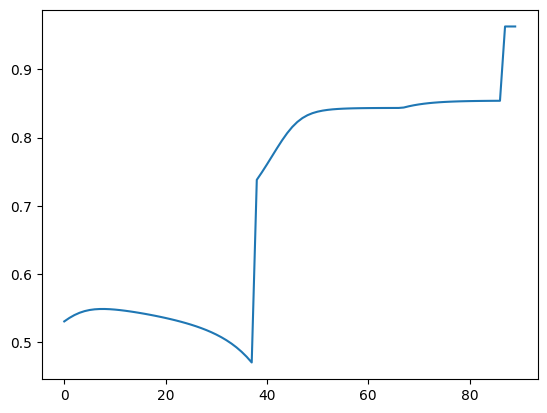

In [13]:
plt.plot(mcc)

In [15]:
# LaTeX code for the subplot
subplot_code_ = r'''
\nextgroupplot[
        title=Evolution of MCC during FastICA algorithm iterations on synthetic data,
        xlabel={iterations},
        ylabel={MCC Score},
        xmin=0, xmax=%d,
        ymin=%f, ymax=%f
        ]
\addplot[
    color=blue,
    mark=*,
    style={very thick},
] coordinates {
    %s
};
''' % (len(mcc)-1, min(mcc)-0.1, 1, ' '.join(f'({i},{score:.2f})' for i, score in enumerate(mcc)))

# Save the LaTeX code to a file
file_path = 'report/figures_latex/mcc_toy_sources_fastica.tex'  # Path to save the .tex file
with open(file_path, 'w') as file:
    file.write(subplot_code_.strip())
